In [1]:
"""/* cosyrush.cc ****************************************************************-*-c++-*-
**
**
**
Example program for the GAMMA Project
**
**
**
** The Program reads a spin system (number of spins, chemical shifts and
**
** J-coupling constants) from a file and simulates a normal COSY experiment **
** using RuSH for quadrature detection in t1
**
**
**
** NOTE: Set to work only on HOMONUCLEAR systems
**
**
**
**************************************************************************************** */
#include <gamma.h>
//
Define Constants
const int t1pts = 512;
const int t2pts = 512;
// Number of t1 points
// Number of t2 points
//
Begin Program
main (int argc, char* argv[])
{
cout << “\Homonuclear COSY Simulation with RuSH Mode\n”;
//
Read in the Spin System
String filename;
query_parameter(argc, argv, 1,
“\nSpin system filename? “, filename);
spin_system sys;
sys.read(filename);
//
22
1.5
COSY with RuSH Method
// Name of spin system file
// Get filename from command
// line or ask for it
// Declare spin system sys
// Read system from filename
gen_op Upx = Ixypuls_U(sys,0.0,90.0);
gen_op Upy = Ixypuls_U(sys,90.0,90.0);
gen_op Ud1 = prop(H, t1dt);
gen_op D = Fm(sys);
gen_op sigma0, sigma1, sigma2, sigma3;
block_1D t2BLK(t2pts);
//
// Propagator for x pulse
// Propagator for y pulse
// Propagator t1 delay increment
// Detector to F-
// Set up density matrices
// Set 1D block for output
Pulse Sequence and I/O Setup
File cosyRe, cosyIm;
// Declare and open two files
cosyRe.open(“cosyRuSH.Redat”,io_writeonly, a_create);
cosyIm.open(“cosyRuSH.Imdat”,io_writeonly, a_create);
//
Apply Pulse Sequence
gen_op sigma0 = sigma_eq(sys);
gen_op sigma1 = evolve(sigma0, Upx);
gen_op sigma2 = sigma1;
for (int t1=0; t1<t1pts; t1++)
{
sigma3 = evolve(sigma2, Upx);
FID(sigma3,D,H,t2dt,t2pts,t2BLK);
Felix(cosyRe, t2BLK);
sigma3 = evolve(sigma2, Upy);
FID(sigma3,D,H,t2dt,t2pts,t2BLK);
Felix(cosyIm, t2BLK);
evolve_ip(sigma2, Ud1);
}
cosyRe.close();
cosyIm.close();
}
// Set density matrix equilibrium
// Apply first (PI/2)x pulse
// Initial sigma2 (t1 = 0)
// Loop over all t1 increments
// Apply second (PI/2)x pulse
//Acquire data for reals
// Output block for reals: Felix
// Apply second (PI/2)y pulse
//Acquire data for imaginaries
// Output block for imags: Felix
//evolution to next t1
// Close files
Set Offsets and Spectral Widths
double offset = sys.center();
sys.offsetShifts(offset);
double NyqF = sys.Nyquist(0, 1.4);
double t2dt = 1.0/(2.0*NyqF);
double t1dt = t2dt;
//
// Find approx. spectrum center
// Offset shifts so centered
// Approximate Nyquist frequency
// t2 time increment
// t1 time increment
Set Up Hamiltonian
char J;
query_parameter(argc, argv, 2,
“\nWeak or strong coupling (w/s)?”, J);
gen_op H;
if (J == ‘w’)
H = Hcs(sys) + HJw(sys);
else
H = Hcs(sys) + HJ(sys);
""";

In [2]:
import pygamma
import pylab
import numpy
 
#import nmrglue
from pygamma import spin_system, Hcs, HJw, HJ, Fm, gen_op, sigma_eq, Iypuls, evolve, FID, row_vector,Iypuls_U, evolve_ip

from scipy import fftpack

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

%matplotlib inline

### DEFINE SYSTEM & NMR PARAMETERS

In [3]:
dt1 = 0.001 # t1 time increment
dt2 = 0.001 # t2 time increment
t1pts = 1024 # points on t1 axis
t2pts = 1024 # points on t2 axis

In [4]:
sys=spin_system()     # define the system, read in
sys.read("cosy1.sys") # from disk

print sys

Spin Index :      0            1            2      
Isotope    :      1H           1H           1H     
Momentum   :     1/2          1/2          1/2     
Shifts     :     0.00 Hz      0.00 Hz      0.00 Hz 
           :     0.50 ppm     0.25 ppm     0.10 ppm
Js Spin 0  :                 10.00 Hz      0.00 Hz 
Js Spin 1  :                              15.00 Hz 
Omega      :   400.00 MHz   400.00 MHz   400.00 MHz



### Set Offsets and Spectral Widths

In [5]:
"""
Set Offsets and Spectral Widths

double offset = sys.center();
sys.offsetShifts(offset);
double NyqF = sys.Nyquist(0, 1.4);
double t2dt = 1.0/(2.0*NyqF);
double t1dt = t2dt;
""";

In [6]:
offset = sys.center();
sys.offsetShifts(offset);
NyqF = sys.Nyquist(0, 1,4);
t2dt = 1.0/(2.0*NyqF);
t1dt = t2dt;

print t1dt,1./t1dt

0.0047619047619 210.0


### SET UP NECESSARY VARIABLES


In [9]:
tmp = row_vector(t2pts)                                    #block_1D tmp(t2pts); // 1D-data block storage
data1 = numpy.zeros((t1pts,t2pts), dtype=numpy.complex128) #block_2D data(t1pts,t2pts); // 2D-data matrix storage
data2 = numpy.zeros((t1pts,t2pts), dtype=numpy.complex128) #block_2D data(t1pts,t2pts); // 2D-data matrix storage

H = Hcs(sys)                                  # // Hamiltonian, weak coupling
#H = Hcs(sys)+ HJw(sys)                                    # // Hamiltonian, weak coupling
#H = Hcs(sys)+ HJ(sys)                                    # // Hamiltonian, strong coupling


Upx = pygamma.Ixypuls_U(sys, 0.0,90.0);
Upy = pygamma.Ixypuls_U(sys,90.0,90.0);
Ud1 = pygamma.prop(H, t1dt);
D = gen_op(Fm(sys))

### APPLY PULSE SEQUENCE

In [10]:
"""Apply Pulse Sequence
gen_op sigma0 = sigma_eq(sys);
gen_op sigma1 = evolve(sigma0, Upx);
gen_op sigma2 = sigma1;

for (int t1=0; t1<t1pts; t1++)
{
    sigma3 = evolve(sigma2, Upx);
    FID(sigma3,D,H,t2dt,t2pts,t2BLK);
    Felix(cosyRe, t2BLK);
    
    sigma3 = evolve(sigma2, Upy);
    FID(sigma3,D,H,t2dt,t2pts,t2BLK);
    Felix(cosyIm, t2BLK);
    evolve_ip(sigma2, Ud1);
}""";

In [11]:

sigma0 = sigma_eq(sys);
sigma1 = evolve(sigma0, Upx);
sigma2 = evolve(sigma0, Upx);

In [12]:
for t1 in range(t1pts):
    sigma3 = evolve(sigma2, Upx)
    FID(sigma3,D,H,t2dt,t2pts,tmp)
    data1[t1] =  tmp.toNParray()
    
    sigma3 = evolve(sigma2, Upy)
    FID(sigma3,D,H,t2dt,t2pts,tmp)
    data2[t1] =  tmp.toNParray()
    evolve_ip(sigma2, Ud1);


### Apply QSIN processing in both dimensions, 2D-FFT and display in absolute mode

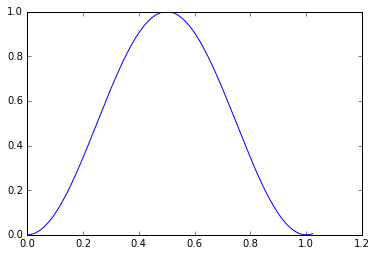

In [40]:
ph1 = pylab.pi/1.
aq = 1./dt2

ttt = numpy.arange(t2pts)/aq

qsin = (pylab.sin((2.0*pylab.pi-ph1)*ttt+ph1))**2
pylab.plot(ttt,qsin);

In [41]:
ddd1 =  qsin*data1
ddd2 =  qsin*data2

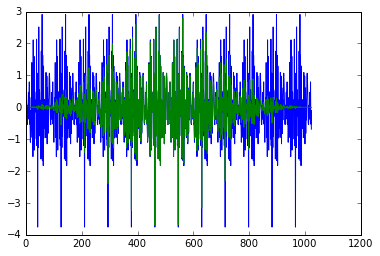

In [44]:
pylab.plot(data1[1].real);
pylab.plot(ddd1[1].real);

In [13]:
fid1 = fftpack.fft(ddd1, axis=1)
fid1 = fftpack.fftshift(fid1, axes=1)

fid2 = fftpack.fft(ddd2, axis=1)
fid2 = fftpack.fftshift(fid2, axes=1)

In [14]:
fid = fid1.real+1j*fid2.real

In [15]:
fid = qsin*(fid.transpose())

In [16]:
spec = fftpack.fft(fid, axis=1)

In [17]:
spec = fftpack.fftshift(spec, axes=1)

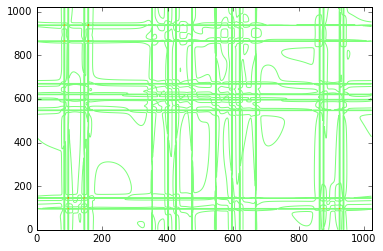

In [18]:
absSpec = (spec)
absSpec = numpy.fliplr(absSpec)   # flip spectrum up down and left to right to obtain correct  Bruker configuration
absSpec = numpy.flipud(absSpec)
pylab.contour(absSpec.real);

### Plot in ppm making use of NMRGLUE python package

In [19]:
info = {}
pinfo = {}

In [20]:
pinfo['procs']={}
pinfo['proc2s']={}

In [21]:
pinfo['procs']['OFFSET']=1.25

In [22]:
pinfo['procs' ]['SW_p']=1.0/dt1

In [23]:
pinfo['procs' ]['SF']=sys.spectrometer_frequency()

In [24]:
pinfo['proc2s' ]['OFFSET'] =1.25
pinfo['proc2s' ]['SW_p']=1.0/dt2
pinfo['proc2s' ]['SF']=sys.spectrometer_frequency()
        
        
        

In [25]:
class TwoD_NMR_MAT_plot:
    
    def __init__(self, exp, pinfo, info, dimensions_ppm=[]):
        
#        print exp.shape
        
        self.exp = exp
        self.pinfo = pinfo
        self.info  = info
        
        self.rr,self.cc = exp.shape
        self.X = numpy.zeros(exp.shape)
        self.Y = numpy.zeros(exp.shape)
        
        r1=0
        r2=self.rr

        c1=0
        c2=self.cc
        
#        print r2,c2
        
        self.create_axes(  pinfo, info, self.rr, self.cc, dimensions_ppm )
          
        self.create_plot_layout(self.dimensions_index)
        
        self.plot_plots()
        

        
    def create_axes( self, pinfo, info, rr,cc, dimensions_ppm):
                
        self.f1_offset_p = pinfo['procs' ]['OFFSET']
        self.f1_sw_hz     = pinfo['procs' ]['SW_p']
        self.f1_omega    = pinfo['procs' ]['SF']
        self.f1_sw_ppm   = self.f1_sw_hz/self.f1_omega
        
        self.f2_offset_p = pinfo['proc2s' ]['OFFSET']
        self.f2_sw_hz     = pinfo['proc2s' ]['SW_p']
        self.f2_omega    = pinfo['proc2s' ]['SF']
        self.f2_sw_ppm   = self.f2_sw_hz/self.f2_omega
#        print self.f1_sw_ppm
        
        self.f1 = numpy.linspace(self.f1_offset_p, self.f1_offset_p-self.f1_sw_ppm,  self.rr)
        self.f2 = numpy.linspace(self.f2_offset_p, self.f2_offset_p-self.f2_sw_ppm,  self.cc)
        
        self.dw_f1_ppm = self.f1[1]-self.f1[0]
        self.dw_f2_ppm = self.f2[1]-self.f2[0]
        
        for r in range(self.rr):
    
            for c in range( self.cc):
        
                self.Y[r,c] = self.f1[r]
                self.X[r,c] = self.f2[c] 
                
#        print dimensions_ppm       
        if dimensions_ppm == []:
            self.dimensions_index = numpy.array([0,self.rr-1,0,self.cc-1])
        else:
            r1 = int( (dimensions_ppm[1]-self.f1_offset_p)/self.dw_f1_ppm)
            r2 = int( (dimensions_ppm[0]-self.f1_offset_p)/self.dw_f1_ppm)
            c1 = int( (dimensions_ppm[2]-self.f2_offset_p)/self.dw_f2_ppm)
            c2 = int( (dimensions_ppm[3]-self.f2_offset_p)/self.dw_f2_ppm)
            
            self.dimensions_index = numpy.array([r1,r2,c1,c2 ])
            
#        print "self.dimensions_index", self.dimensions_index
            
        self.Z1 = self.exp[self.dimensions_index[0]:self.dimensions_index[1],self.dimensions_index[2]:self.dimensions_index[3]]
        self.X1 =   self.X[self.dimensions_index[0]:self.dimensions_index[1],self.dimensions_index[2]:self.dimensions_index[3]]
        self.Y1 =   self.Y[self.dimensions_index[0]:self.dimensions_index[1],self.dimensions_index[2]:self.dimensions_index[3]]
        
        
    def create_plot_layout( self, dimensions_index):
        
#        print "dimensions_index",dimensions_index
        
        nullfmt   = NullFormatter()         # no labels

        # definitions for the axes
        left, width = 0.1, 0.65
        bottom, height = 0.1, 0.65
        bottom_h = left_h = left+width+0.02

        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom_h, width, 0.2]
        rect_histy = [left_h, bottom, 0.2, height]

        # start with a rectangular Figure
        plt.figure(2, figsize=(6,6))

        self.axScatter = plt.axes(rect_scatter)
        self.axHistx = plt.axes(rect_histx)
        self.axHisty = plt.axes(rect_histy)

# no labels
        self.axHistx.xaxis.set_major_formatter(nullfmt)
        self.axHisty.yaxis.set_major_formatter(nullfmt)
        
        self.axScatter.tick_params(axis='x', labelsize=16)
        self.axScatter.tick_params(axis='y', labelsize=16)
        self.axScatter.set_xlabel('${^1}$H [ppm]',fontsize=16)
        #ax.set_xlim(-60, 60)
        self.axScatter.set_ylabel('${^1}$H [ppm]', fontsize=16)
        
        self.axHistx.axis('off')
        self.axHisty.axis('off')

        f1_start = self.f1[dimensions_index[0]]
        f1_end   = self.f1[dimensions_index[1]]

        f2_start = self.f2[dimensions_index[2]]
        f2_end   = self.f2[dimensions_index[3]]

        self.axScatter.set_ylim( (f1_start, f1_end) )
        self.axScatter.set_xlim( (f2_start, f2_end) )
        
        

    def plot_plots(self):
        
        # the scatter plot:
        cl = numpy.linspace(self.Z1.max()*0.01, self.Z1.max()*1.1,10)
#        print "Z1.shape",self.Z1.shape
        

        sum_f1 = self.Z1.sum(axis=0)
#        print "len(sum_f1)",len(sum_f1)
        sum_f2 = self.Z1.sum(axis=1)
#        print "len(sum_f2)",len(sum_f2)

        cset = self.axScatter.contour(self.X1, self.Y1, self.Z1,  cl,  colors='red')
        #
        self.axHistx.plot(sum_f1, 'r-')
        self.axHisty.plot(sum_f2,range(len(sum_f2)),'r')


        self.axHistx.set_xlim( (0,len(sum_f1)-1) )
        self.axHisty.set_ylim( (0,len(sum_f2)-1) )        
        


In [26]:
#ppplot = TwoD_NMR_MAT_plot2(absSpec, pinfo, info, )

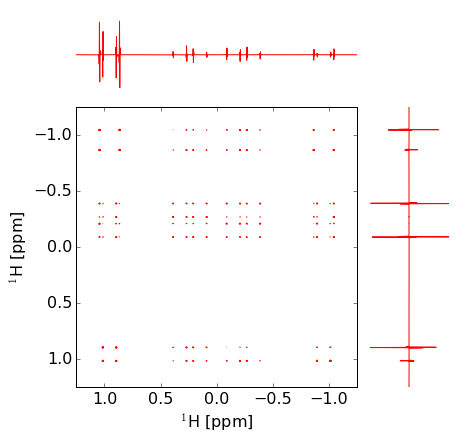

In [27]:
ppplot = TwoD_NMR_MAT_plot(absSpec.real, pinfo, info )

In [28]:
print help(evolve_ip)

Help on function evolve_ip in module pygamma.pygamma:

evolve_ip(*args)
    evolve_ip(gen_op sigma, gen_op ham, double time)
    evolve_ip(gen_op sigma, gen_op U)

None
